In [19]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pickle
from keras.utils.np_utils import to_categorical
import keras_tuner as kt
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [5]:
#important landmarks
landmarks = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "RIGHT_ELBOW",
    "LEFT_ELBOW",
    "RIGHT_WRIST",
    "LEFT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
]



HEADERS = ["label"]

for lm in landmarks:
    HEADERS += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [6]:
print(HEADERS)

['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']


In [7]:
def describe_dataset(dataset_path: str):


    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

In [8]:
# load dataset
df = describe_dataset("/content/drive/MyDrive/train_trest_bc/bc/train.csv")

# Categorizing label
df.loc[df["label"] == "C", "label"] = 0
df.loc[df["label"] == "L", "label"] = 1

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']
Number of rows: 15372 
Number of columns: 37

Labels: 
C    8238
L    7134
Name: label, dtype: int64

Missing values: False

Duplicate Rows : 0


In [9]:
with open("/content/drive/MyDrive/train_trest_bc/model/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
# Standard Scaling of features
x = df.drop("label", axis = 1)
x = pd.DataFrame(sc.transform(x))

y = df["label"]

# # Converting prediction to categorical
y_cat = to_categorical(y)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y_cat, test_size=0.2, random_state=1234)

In [12]:
def describe_model(model):
    '''
    Describe Model architecture
    '''
    print(f"Describe models architecture")
    for i, layer in enumerate(model.layers):
        number_of_units = layer.units if hasattr(layer, 'units') else 0

        if hasattr(layer, "activation"):
            print(f"Layer-{i + 1}: {number_of_units} units, func: ", layer.activation)
        else:
            print(f"Layer-{i + 1}: {number_of_units} units, func: None")

In [13]:
def get_best_model(tuner):
    '''
    Describe and return the best model found from keras tuner
    '''
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)

    describe_model(best_model)

    print("\nOther params:")
    ignore_params = ["tuner", "activation", "layer", "epoch"]
    for param, value in best_hps.values.items():
        if not any(word in param for word in ignore_params):
            print(f"{param}: {value}")

    return best_model

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=3)

# Final Results
final_models = {}

In [15]:
def model_builder(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(36, input_dim = 36, activation = "relu"))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value=32, max_value=512, step=32)
    hp_layer_2 = hp.Int('layer_2', min_value=32, max_value=512, step=32)
    hp_layer_3 = hp.Int('layer_3', min_value=32, max_value=512, step=32)
    hp_layer_4 = hp.Int('layer_4', min_value=32, max_value=512, step=32)
    hp_layer_5 = hp.Int('layer_5', min_value=32, max_value=512, step=32)
    hp_layer_6 = hp.Int('layer_6', min_value=32, max_value=512, step=32)
    hp_layer_7 = hp.Int('layer_7', min_value=32, max_value=512, step=32)
    hp_layer_8 = hp.Int('layer_8', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_3, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_4, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_5, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_6, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_7, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_8, activation=hp_activation))
    model.add(tf.keras.layers.Dense(2, activation = "softmax"))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [16]:
tuner_dl = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo_6'
)
tuner_dl.search(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Trial 30 Complete [00h 01m 04s]
val_accuracy: 0.546016275882721

Best val_accuracy So Far: 0.9983739852905273
Total elapsed time: 00h 15m 00s


In [17]:
model_dl = get_best_model(tuner_dl)
history=model_dl.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), callbacks=[stop_early])

Describe models architecture
Layer-1: 36 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-2: 96 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-3: 512 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-4: 96 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-5: 320 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-6: 512 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-7: 160 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-8: 384 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-9: 128 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-10: 2 units, func:  <function softmax at 0x7fe2332a7a30>

Other params:
learning_rate: 0.0001
Epoch 1/100
1230/1230 [==============================] - 17s 13ms/step - loss: 0.0853 - accuracy: 0.9715 - val_loss: 0.0216 - val_accuracy: 0.9958
Epoch 2/100
1230/1230 [==============================] - 14s 11ms/step - loss: 0.0259 - accuracy: 0.9927 - val_loss: 0.0266 - val_accuracy: 0.9922
Epoch 3/100
1230/1230 [========

In [18]:
describe_model(model_dl)

Describe models architecture
Layer-1: 36 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-2: 96 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-3: 512 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-4: 96 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-5: 320 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-6: 512 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-7: 160 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-8: 384 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-9: 128 units, func:  <function relu at 0x7fe2332bc4c0>
Layer-10: 2 units, func:  <function softmax at 0x7fe2332a7a30>


In [24]:
evaluate = model_dl.evaluate(x=x_test,y=y_test)

97/97 [==============================] - 1s 5ms/step - loss: 0.0099 - accuracy: 0.9980


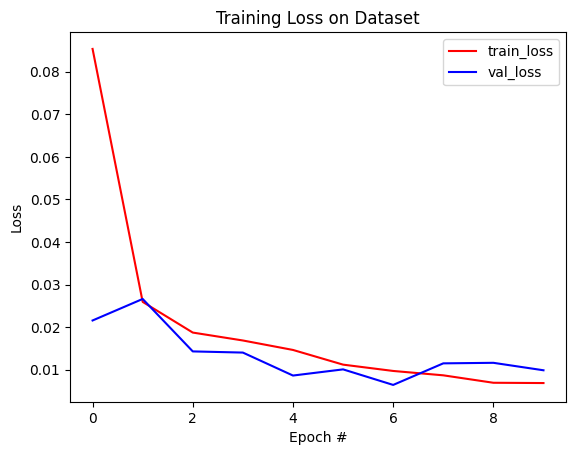

In [25]:
epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

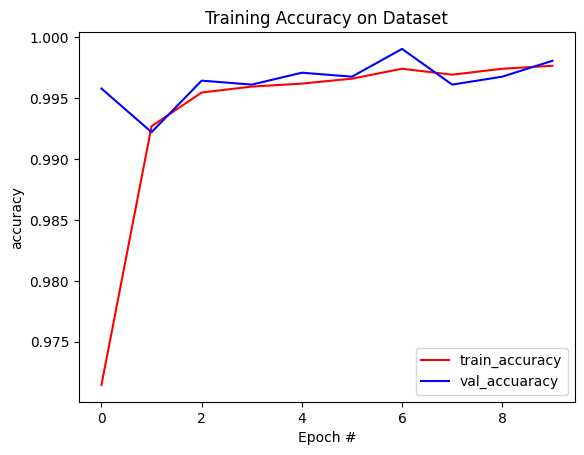

In [26]:
epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['accuracy'], 'red', label = 'train_accuracy')
plt.plot(epoch, history.history['val_accuracy'], 'blue', label = 'val_accuaracy')
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend()

In [ ]:
model_dl.save("/content/drive/MyDrive/train_trest_bc/model/bicep_dl.h5")